<a href="https://colab.research.google.com/github/utsav-195/text-to-image-synthesizer-gan/blob/main/text_to_image_synthesizer_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np

from urllib.request import urlopen

In [ ]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [ ]:
glove_embeddings = loadGloveModel("/content/drive/MyDrive/flowers/glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [ ]:
train_data_path = "/content/drive/MyDrive/flowers"
train_images_path = "/content/drive/MyDrive/flowers/jpg"
train_captions_path = "/content/drive/MyDrive/flowers/text_c10"

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
GENERATE_RES = 2
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100
EMBEDDING_SIZE = 300

DATA_PATH = train_images_path
MODEL_PATH = "/content/drive/MyDrive/flowers/model"
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


## Pre-Processing

In [ ]:

training_binary_path = os.path.join("/content/drive/MyDrive/flowers/images/npy64",
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))

for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    try:
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_data) == 100:
      training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
      training_data = training_data.astype(np.float32)
      training_data = training_data / 127.5 - 1.

      print("Saving training image " + str(100000 + filename) + ".npy")
      np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
      elapsed = time.time()-start
      print (f'Image preprocess time: {hms_string(elapsed)}')
      training_data = []
print("Complete")

Loading training images...
Saving training image 100099.npy
Image preprocess time: 0:02:26.37
Saving training image 100199.npy
Image preprocess time: 0:02:28.33
Saving training image 100299.npy
Image preprocess time: 0:02:30.03
Saving training image 100399.npy
Image preprocess time: 0:02:31.79
Saving training image 100499.npy
Image preprocess time: 0:02:33.26
Saving training image 100599.npy
Image preprocess time: 0:02:35.05
Saving training image 100699.npy
Image preprocess time: 0:02:37.37
Saving training image 100799.npy
Image preprocess time: 0:02:39.05
Saving training image 100899.npy
Image preprocess time: 0:02:40.76
Saving training image 100999.npy
Image preprocess time: 0:02:42.22
Saving training image 101099.npy
Image preprocess time: 0:02:44.72
Saving training image 101199.npy
Image preprocess time: 0:02:47.29
Saving training image 101299.npy
Image preprocess time: 0:02:49.59
Saving training image 101399.npy
Image preprocess time: 0:02:51.53
Saving training image 101499.npy
Im

In [ ]:
text_path = "/content/drive/MyDrive/flowers/text_c10/captions"
text_files = sorted(os.listdir(text_path))
captions = []
caption_embeddings = np.zeros((len(text_files),300),dtype=np.float32)
for filename in range(len(text_files)):
    path = os.path.join(text_path,text_files[filename])
    f = open(path,'r')
    data = f.read()
    data = data.split("\n")
    f.close()
    for d in range(1):
      x = data[d].lower()
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          pass
      caption_embeddings[filename] /= count
    if filename %100 == 0:
      print("-------------Files completed:",filename)

-------------Files completed: 0
-------------Files completed: 100
-------------Files completed: 200
-------------Files completed: 300
-------------Files completed: 400
-------------Files completed: 500
-------------Files completed: 600
-------------Files completed: 700
-------------Files completed: 800
-------------Files completed: 900
-------------Files completed: 1000
-------------Files completed: 1100
-------------Files completed: 1200
-------------Files completed: 1300
-------------Files completed: 1400
-------------Files completed: 1500
-------------Files completed: 1600
-------------Files completed: 1700
-------------Files completed: 1800
-------------Files completed: 1900
-------------Files completed: 2000
-------------Files completed: 2100
-------------Files completed: 2200
-------------Files completed: 2300
-------------Files completed: 2400
-------------Files completed: 2500
-------------Files completed: 2600
-------------Files completed: 2700
-------------Files completed: 28

In [ ]:
embedding_binary_path = os.path.join('/content/drive/MyDrive/flowers/images/embedding_npy',
        f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

Saving captions embeddings binary...


In [ ]:
df_captions = pd.DataFrame([])
df_captions['captions'] = captions[:len(final_images)]

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


In [ ]:
captions[:10]

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.']

In [ ]:
df_captions.to_csv("/content/drive/MyDrive/flowers/text_c10/captions.csv",index=None)

In [ ]:
embedding_binary_path = os.path.join('/content/drive/MyDrive/flowers/images/embedding_npy',
        f'embedding_data.npy')

In [ ]:
caption_embeddings = np.load(embedding_binary_path)

In [ ]:
caption_embeddings.shape

(8189, 300)

In [ ]:
caption_embeddings = caption_embeddings[::]

In [ ]:
caption_embeddings.shape

(8189, 300)

In [ ]:
image_binary_path = "/content/drive/MyDrive/flowers/images/npy64/"
images = os.listdir(image_binary_path)

In [ ]:
images[-1]

'training_data_64_64_101199.npy'

In [ ]:
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
  except:
    pass

training_data_64_64_101399.npy
training_data_64_64_101499.npy
training_data_64_64_101599.npy
training_data_64_64_101799.npy
training_data_64_64_101899.npy
training_data_64_64_101699.npy
training_data_64_64_101999.npy
training_data_64_64_102099.npy
training_data_64_64_102199.npy
training_data_64_64_102299.npy
training_data_64_64_102399.npy
training_data_64_64_102499.npy
training_data_64_64_102599.npy
training_data_64_64_102699.npy
training_data_64_64_102799.npy
training_data_64_64_102899.npy
training_data_64_64_102999.npy
training_data_64_64_103099.npy
training_data_64_64_103199.npy
training_data_64_64_103399.npy
training_data_64_64_103299.npy
training_data_64_64_103499.npy
training_data_64_64_103599.npy
training_data_64_64_103699.npy
training_data_64_64_103799.npy
training_data_64_64_103899.npy
training_data_64_64_103999.npy
training_data_64_64_104099.npy
training_data_64_64_104199.npy
training_data_64_64_104299.npy
training_data_64_64_104399.npy
training_data_64_64_104599.npy
training

In [ ]:
final_images.shape

(8100, 64, 64, 3)

In [ ]:
df_captions = pd.read_csv("/content/drive/MyDrive/flowers/text_c10/captions.csv")

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


In [ ]:
captions = list(df_captions.captions[::])

In [ ]:
len(captions)

8189

In [ ]:
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

In [ ]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]

In [ ]:
caption_embeddings.shape

(8100, 300)

In [ ]:
p = np.random.permutation(len(final_images))

In [ ]:
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]

In [ ]:
final_images_shuffled.shape

(8100, 64, 64, 3)

In [ ]:
final_embeddings_shuffled.shape

(8100, 300)

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator_func(seed_size,embedding_size, channels):
  input_seed = Input(shape=seed_size)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
def save_images(cnt,noise,embeds):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = "/content/drive/MyDrive/flowers/output_64_character_extended"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
# generator.load_weights("/content/drive/MyDrive/flowers/model/text_to_image_generator_cub_character.h5")

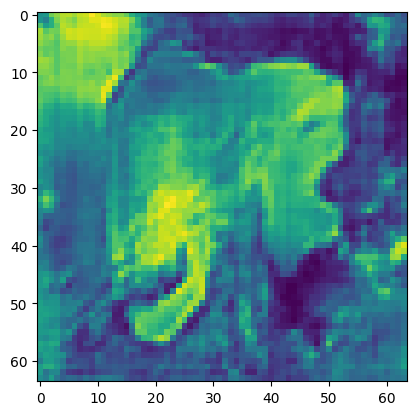

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)

In [ ]:
decision = discriminator((generated_image,caption_embeddings[5].reshape(1,300)))
print(decision)

tf.Tensor([[0.49585307]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) +
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

In [ ]:

@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)


    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(train_dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:

      train_batch = batch['images']
      caption_batch = batch['embeddings']

      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)

      t = train_step(train_batch,caption_batch,fake_caption_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)

    generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
    discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
    print("model saved")

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))


In [ ]:
train(list(train_dataset.as_numpy_iterator()), 500)

epoch start...
now
Epoch 1, gen loss=0.7759312391281128,disc loss=1.5098692178726196, 0:44:11.84
1/1 [==============================] - 3s 3s/step
model saved
epoch start...


## Results

In [ ]:
save_images_embeddings.shape

(28, 300)

In [ ]:
save_images_captions

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.',
 'this flower has petals that are pink with stringy white stamen',
 'this flower has star shaped white petals as its main feature.',
 'lower petals are white in color,and larger in size,inner petals are purple in clor',
 'this flower has petals in 

In [ ]:
def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_images(num,noise,test_embeddings)

In [ ]:
test_image("this flower is purple in color with oval shaped petals",1)

 
 
 
 
 
 
 
 
 
1/1 [==============================] - 1s 1s/step


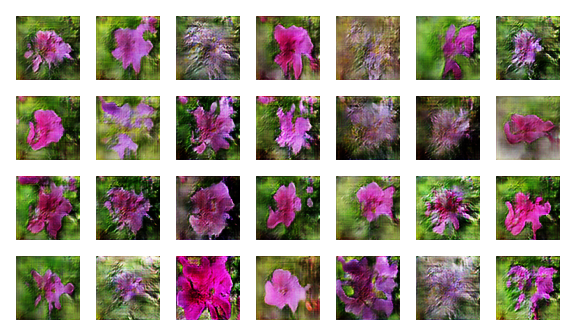

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/flowers/output_64_character_extended/train-1.png')

In [ ]:
test_image("this flower is yellow in color with oval shaped petals",1)

 
 
 
 
 
 
 
 
 
1/1 [==============================] - 0s 34ms/step


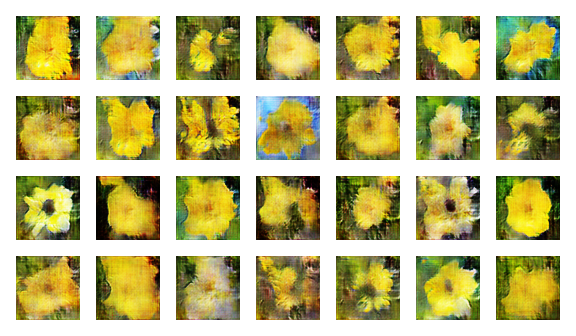

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/flowers/output_64_character_extended/train-1.png')

In [ ]:
test_image("this flower has five very smooth white petals with rounded edges",4)

 
 
 
 
 
 
 
 
 
 
1/1 [==============================] - 0s 23ms/step


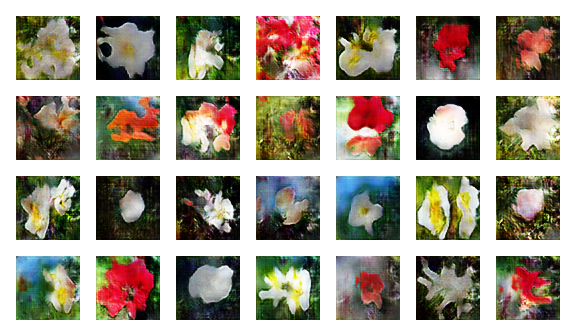

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/flowers/output_64_character_extended/train-4.png')